In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.text import Text
import seaborn as sns; sns.set_style("white")
import plotly.graph_objects as go
%matplotlib inline


# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1')
print(os.getcwd())


/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1
/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1


pip install -U kaleido 

In [62]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [63]:
cell_line = 'HT29'
data_type = '2D' # Leave this as 2D for now

In [64]:
# Load the data
dir = '1_Data/results/'
data =  pd.read_parquet(('{}grit_data_{}_{}.parquet').format(dir, data_type, cell_line))

In [65]:
# Save the data
ImagesOut = '3_Figure3/Radarplots/result-images/'

if not os.path.exists(ImagesOut): 
        os.makedirs(ImagesOut)

In [66]:
## Prepare the metadata for the grit calculation
dataset_aggregated = data.copy()


# Add a column with the step of the concentration (easier for plotting)
dataset_aggregated['Metadata_conc_step'] = (
    dataset_aggregated.groupby('Metadata_cmpdname')['Metadata_cmpd_conc'].rank(ascending=True, method='dense')
    )
# Add a column with the name of the perturbation (compound + concentration)
dataset_aggregated["Metadata_pert_name"] = (
    dataset_aggregated["Metadata_name"] + "_" + dataset_aggregated["Metadata_cmpd_conc"].astype(str)
    )


In [67]:
def get_featurecols(df):
    """return a list of featuredata columns"""
    return [c for c in df.columns if not c.startswith("Metadata")]

# Some function definitions

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata

In [68]:
# Load annotated list of features 
grouping = pd.read_csv('3_Figure3/Radarplots/Features_grouping_2D.csv', sep=',')  # group features in 38 categories for 2D
# grouping = pd.read_csv('3_Radarplots/Features_grouping_v7.csv', sep=',')  # group features in 38 categories for spheroids
grouping = grouping[['Feature_name', 'CHAN-MOD_biorelevant_38cat']]
grouping = grouping.set_index('Feature_name')


In [69]:
dataset_aggregated = dataset_aggregated.dropna(axis='columns', how='all')

In [70]:
## Am I missing any features?
print("Number of features in the annotated list: {}".format(len(grouping)))
print("Number of features in the selected data: {}".format(len(get_featurecols(dataset_aggregated))))

# Check if all features are present in the annotated list
missing_features = []
missing_features2 = []
for feature in grouping.index:
    if feature not in get_featurecols(dataset_aggregated):
        missing_features.append(feature)

for feature in get_featurecols(dataset_aggregated):
    if feature not in grouping.index:
        missing_features2.append(feature)
print("Number of features missing in the annotated list: {}".format(len(missing_features)))
print("Number of features missing in the selected data: {}".format(len(missing_features2)))
## print("Missing features: {}".format(missing_features))


Number of features in the annotated list: 2104
Number of features in the selected data: 881
Number of features missing in the annotated list: 1225
Number of features missing in the selected data: 2


In [71]:
# List features
ListOfSelectedFeatures = list(dataset_aggregated.columns.values)
ListOfMetadata = list(dataset_aggregated.columns[dataset_aggregated.columns.str.contains("Metadata_")])
ListOfSelectedFeatures = list(set(ListOfSelectedFeatures) - set(ListOfMetadata))

# List compounds that are not controls
CompoundList = dataset_aggregated.loc[dataset_aggregated['Metadata_pert_type'] == 'trt', 'Metadata_name'].unique()


In [72]:
## Prepping the data for the radarplot

# Compute the mean for selected features grouped by 'Metadata_pert'
groupedby = dataset_aggregated.groupby('Metadata_pert_name')[ListOfSelectedFeatures].median()

# Prepare the Radarplot DataFrame
RadarplotDf = groupedby.abs().transpose()

# Merge with 'grouping' DataFrame based on index
df_merged = pd.merge(left=RadarplotDf, right=grouping, left_index=True, right_index=True, how='left')

# Group by 'CHAN-MOD_biorelevant_38cat' and compute the mean
df_38cat = df_merged.groupby('CHAN-MOD_biorelevant_38cat').mean().round(decimals=5).transpose()

# Remove rows with infinite values
df_38cat = df_38cat.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Extract feature groups and create categories list
feature_groups = list(df_38cat.columns)
categories = [*feature_groups, feature_groups[0]]

# Extract 'Metadata_name' and 'Metadata_cmpd_conc' from index
df_38cat['Metadata_name'] = df_38cat.index.str.split('_').str[0]
df_38cat['Metadata_cmpd_conc'] = df_38cat.index.str.split('_').str[1].astype(float)

In [73]:
cmap = sns.color_palette("Blues_r", 5)

In [74]:
CompoundList = ['SN-38', 'Binim', 'abema']

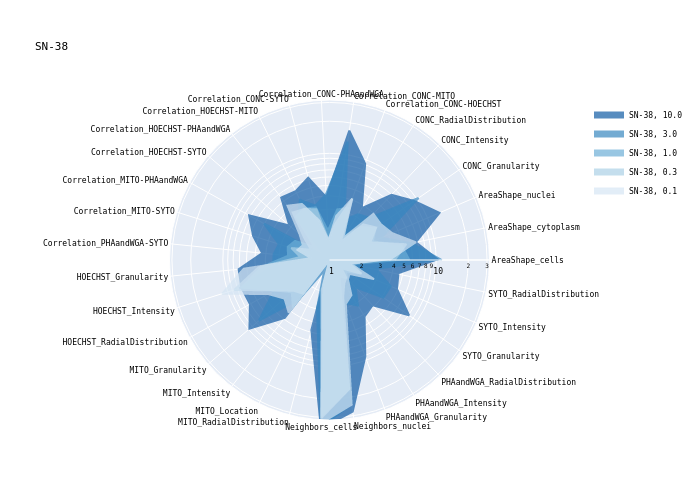

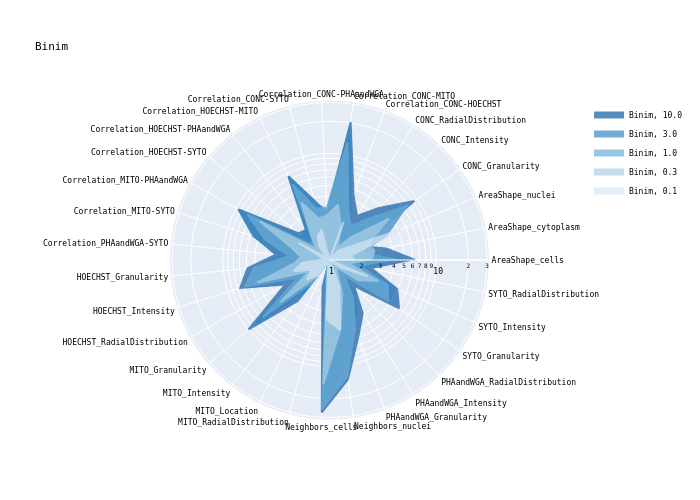

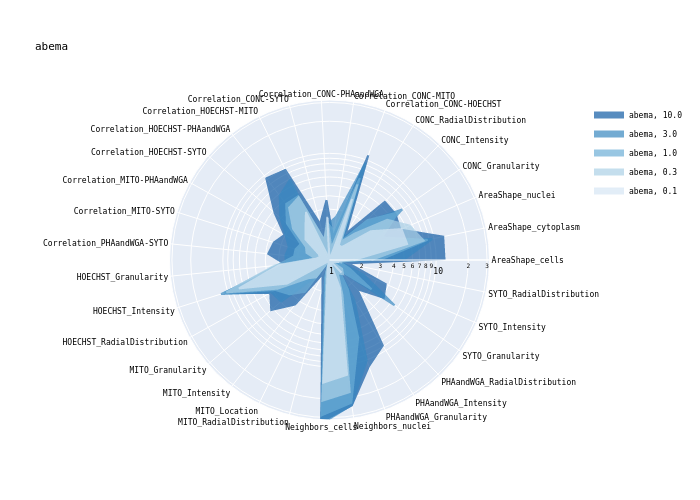

In [75]:
## Plot compound radarplots

color_palette = sns.color_palette(cmap,6).as_hex()

for compound in CompoundList:
    df_38cat_part = df_38cat[df_38cat['Metadata_name'] == compound].copy()
    doses = sorted(list(set(df_38cat_part['Metadata_cmpd_conc'])), reverse=True)

    traces = []
    for i, dose in enumerate(doses[:5]):
        try:
            color = color_palette[i % len(color_palette)]
            data_point = df_38cat_part.loc["{}_{}".format(compound, dose)]
            trace = go.Scatterpolar(
                r=data_point, theta=categories, fill='toself',
                opacity=0.7, line_color=color, fillcolor=color,
                connectgaps=True, name="{}, {}".format(compound, dose)
            )
            traces.append(trace)
        except: 
            print("Missing data for {}_{}".format(compound, dose))

    fig = go.Figure(data=traces, layout=go.Layout(
        title=go.layout.Title(text='{}'.format(compound)),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    ))

    fig.update_layout(
        polar=dict(radialaxis=dict(type="log", range=[0, 1.5], tickangle=0)),
        showlegend=True,
        font=dict(family="Courier New, monospace", size=8, color="Black")
    )

    fig.show(renderer='png')
    fig.write_image("{}radarplot_2D_{}_{}.pdf".format(ImagesOut, compound, cell_line))
